#Data Mining with Apache Spark, Pandas and IPython (Proof of Concept)

The main purpose of this notebook is to bring several great data mining tools together and use each of them for what they excel in:

* **[IPython (Jupyter) Notebook](http://ipython.org/)** is an interactive computational environment, in which you can combine code execution, rich text, mathematics, plots and rich media.
* **[Pandas](http://pandas.pydata.org/)** is an excellent Python data analysis library which provides high-performance, easy-to-use data structures and data analysis tools. In some ways Pandas is like **R** in Python World. Here is a very nice [10 minutes video tour of pandas](https://vimeo.com/59324550) by Wes McKinney, its creator. Even though Pandas is my favorite data manipulation and analysis tool, but when it comes to so-called BIG DATA, Pandas has its limitations and this is where **Apache Spark** comes to the game.
* **[Apache Spark](https://spark.apache.org/)** is a super-fast engine for large-scale data processing. Here is a very cool demo which should give an impression of what can be done with Spark: https://youtu.be/FjhRkfAuU7I?t=33m48s

The text files used in this exercise are from [AOL search data leak](https://en.wikipedia.org/wiki/AOL_search_data_leak). This data itself is quite interesting, however we will not look for any deep insights as the main idea here is just to test **`BIG DATA` --> `Spark` --> `Pandas` --> `DataViz Libraries`** approach.

This notebook runs on [Anaconda Python 3.4.3](http://continuum.io/downloads) and **Apache Spark 1.4**.  [Pyspark](https://spark.apache.org/docs/0.9.0/python-programming-guide.html) provides API bindings between Python and Spark.

<img style="float: right; margin-right: 60px;" src="bigdata-spark-pandas01.png">
###Table of Contents:
* [Part 1: Reading Raw Data into Apache Spark RDD](#Part-1:-Reading-Raw-Data-into-Apache-Spark-RDD)
* [Part 2: Converting RDD with Raw Data into Spark DataFrame](#Part-2:-Converting-RDD-with-Raw-Data-into-Spark-DataFrame)
* [Part 3: From RDD to Pandas](#Part-3:-From-RDD-to-Pandas)
* [Part 4: Data Visualisation](#Part-4:-Data-Visualisation)

-----

###Part 1: Reading Raw Data into Apache Spark RDD

In [12]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

This will read 10 text files and create an RDD (Resilient Distributed Dataset):

In [13]:
rdd_txt = sc.textFile("/home/yurz/DATA/_TMP/AOL-user-ct-collection/files/user-ct-test-collection-*.txt")

Count number of lines:

In [14]:
rdd_txt.count()

36389577

Let's check how the first 5 lines of the rdd_txt look:

In [15]:
rdd_txt.take(5)

['AnonID\tQuery\tQueryTime\tItemRank\tClickURL',
 '142\trentdirect.com\t2006-03-01 07:17:12\t\t',
 '142\twww.prescriptionfortime.com\t2006-03-12 12:31:06\t\t',
 '142\tstaple.com\t2006-03-17 21:19:29\t\t',
 '142\tstaple.com\t2006-03-17 21:19:45\t\t']

Take the very first line:

In [16]:
header = rdd_txt.first()
header

'AnonID\tQuery\tQueryTime\tItemRank\tClickURL'

Remove lines containing header text:

In [17]:
rdd_txt = rdd_txt.filter(lambda l: l.startswith("AnonID") == False)

Looks like we've "lost" 10 lines of data (if compared to count above), which makes sence since each text file had a header:

In [18]:
rdd_txt.count()

36389567

Let's check number of distinct AnonIDs using `distinct()` or `groupBy()` methods:

In [19]:
rdd_txt.map(lambda l: l.split("\t")[0]).distinct().count()

657427

In [20]:
rdd_txt.groupBy(lambda l: l.split("\t")[0]).count()

657427

Let's see how many users had word **australia** in their search at least once:

In [21]:
rdd_txt.filter(lambda l: "australia" in l.lower()).map(lambda l: l.split("\t")[0]).distinct().count()

3659

---

###Part 2: Converting RDD with Raw Data into Spark DataFrame

Create a new RDD where each row is a list of values instead of raw text:

In [22]:
df = rdd_txt.map(lambda l: l.split("\t"))

Let's catch any problematic rows before we start applying data types and moving to a DataFrame:

In [23]:
from datetime import datetime

In [24]:
def raise_err(r):
    try:
        _ = int(r[0])
        _ = datetime.strptime(r[2], "%Y-%m-%d %H:%M:%S")
        return False
    except:
        return True

In [25]:
err = df.filter(lambda r: raise_err(r))

Looks like there is only one problematic row which would give us **`ValueError: invalid literal for int() with base 10`** if we try converting it to integer. Let's simply filter it out.

In [26]:
err.count()

1

In [27]:
err.take(5)

[['\x19403684',
  'match.com',
  '2006-03-31 06:55:53',
  '2',
  'http://www.match.com']]

In [28]:
df = df.filter(lambda r: raise_err(r) == False)

Now let's apply data types. We only want first three fields:

In [29]:
df = df.map(lambda r: (int(r[0]), r[1], datetime.strptime(r[2], "%Y-%m-%d %H:%M:%S")))

In [30]:
df.first()

(142, 'rentdirect.com', datetime.datetime(2006, 3, 1, 7, 17, 12))

Prepare schema and create DataFrame:

In [31]:
from pyspark.sql.types import *

In [32]:
schema = StructType([
                        StructField("id", IntegerType(), True),
                        StructField("query", StringType(), True),
                        StructField("time", TimestampType(), True)
                    ])

In [33]:
df = sqlContext.createDataFrame(df, schema)

Register DataFrame as a TempTable so we can also run SQL on it:

In [34]:
df.registerTempTable("aol")

Test that SQL works, user 711391 seems to have some nontrivial problems in their personal life...

In [35]:
sqlContext.sql("select * from aol where id = 711391 order by time").show()

+------+--------------------+--------------------+
|    id|               query|                time|
+------+--------------------+--------------------+
|711391|can not sleep wit...|2006-03-01 01:24:...|
|711391|cannot sleep with...|2006-03-01 01:24:...|
|711391|cannot sleep with...|2006-03-01 01:24:...|
|711391|cannot sleep with...|2006-03-01 01:33:...|
|711391|  jackie zeaman nude|2006-03-01 15:26:...|
|711391|   jackie zeman nude|2006-03-01 15:26:...|
|711391|      strange cosmos|2006-03-01 16:07:...|
|711391|mansfield first a...|2006-03-01 16:09:...|
|711391|mansfield first a...|2006-03-01 16:09:...|
|711391|reverend harry myers|2006-03-01 16:10:...|
|711391|reverend harry myers|2006-03-01 16:10:...|
|711391|   national enquirer|2006-03-01 17:13:...|
|711391|how to kill mocki...|2006-03-01 17:18:...|
|711391|how to kill mocki...|2006-03-01 17:18:...|
|711391|how to kill annoy...|2006-03-01 17:18:...|
|711391|how to kill annoy...|2006-03-01 17:19:...|
|711391|how to rid your y...|20

Check time frame of the data set:

In [36]:
df.agg({"time": "min"}).collect()

[Row(MIN(time)=datetime.datetime(2006, 3, 1, 0, 1, 3))]

In [37]:
df.agg({"time": "max"}).collect()

[Row(MAX(time)=datetime.datetime(2006, 5, 31, 23, 59, 59))]

Now let's get a list of the top users:

In [38]:
top_searchers = df.groupby(df.id).count()

In [39]:
top_searchers.sort("count", ascending=False).limit(10).show()

+--------+------+
|      id| count|
+--------+------+
|   71845|279430|
| 2263543|  8695|
|23187425|  8274|
|  117514|  7545|
| 5288646|  7313|
| 3318459|  6925|
|18350315|  5981|
|11112937|  5847|
| 2359287|  5845|
|   42075|  5165|
+--------+------+



---

###Part 3: From RDD to Pandas

The number of search requests made by our top user from the previous step looks unrealistic. The only explanation I can think of is that **user 71845** is not a single person but rather represents a list or category of users. We can copy those **279,430** searches into Pandas and look at them closer:

In [40]:
user_71845 = df[df.id == 71845]

In [41]:
pd_71845 = user_71845.toPandas()

In [42]:
pd_71845.head()

id query                time
0  71845     - 2006-04-04 06:12:36
1  71845     - 2006-04-04 06:57:56
2  71845     - 2006-04-04 07:11:52
3  71845     - 2006-04-04 07:12:02
4  71845     - 2006-04-04 07:14:05

In [43]:
pd_71845.tail()

id                      query                time
279425  71845  how to cut your own bangs 2006-04-10 00:05:00
279426  71845  how to cut your own bangs 2006-04-10 00:05:00
279427  71845                    msn.com 2006-04-10 00:05:02
279428  71845                    msn.com 2006-04-10 00:05:02
279429  71845            victoria secret 2006-04-10 00:05:04

In [44]:
pd_71845[::20000]

id                             query                time
0       71845                                 - 2006-04-04 06:12:36
20000   71845                                 - 2006-04-05 14:49:30
40000   71845                         knobs.com 2006-04-05 21:59:00
60000   71845                                 - 2006-04-06 11:07:14
80000   71845      vincent's almond fish recipe 2006-04-06 18:11:45
100000  71845  final fantasy crystal chronicles 2006-04-07 00:20:55
120000  71845                              ebay 2006-04-07 13:18:34
140000  71845                   century theatre 2006-04-07 20:13:18
160000  71845                       ion thunder 2006-04-08 06:37:51
180000  71845                 www.pokemoncrater 2006-04-08 14:27:11
200000  71845        sterile processing manager 2006-04-08 20:18:55
220000  71845  single females in mobile alabama 2006-04-09 05:16:28
240000  71845                   piss my panties 2006-04-09 14:05:35
260000  71845                     joker tattoos 2006-04-09 19:19:01

Let's also aggregate searches by date (this time using SQL) and copy into Pandas for further visualisation:

In [45]:
sql_by_dates = """
               select cast(time as Date) as dt
                     ,count(*) as cnt
               from aol
               group by cast(time as Date)
               order by dt
               """

In [46]:
by_dates = sqlContext.sql(sql_by_dates)

In [47]:
pd_by_dates = by_dates.toPandas()

In [48]:
pd_by_dates.head()

dt     cnt
0 2006-03-01  454226
1 2006-03-02  474107
2 2006-03-03  428053
3 2006-03-04  467858
4 2006-03-05  515973

---

###Part 4: Data Visualisation

There are quite a few python dataviz libraries that we can use here: matplotlib, vincent, plotly - just to name some. I usually use vincent for quick exploratory visualisation inside of the notebook and javascript libraries like d3.js, dc.js and some others for presenting to users. This time I am going to try [Bokeh](https://github.com/bokeh/bokeh) - it was at version 0.1 or 0.2 when I tested it last time and it seems like it has matured since then. Pay attention to a toolbar above the chart(s) as it provides some very useful functionality - for example you can zoom into dataset to get better detailisation.


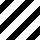
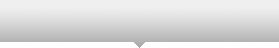
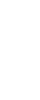
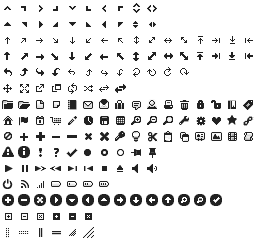
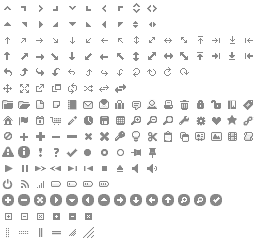
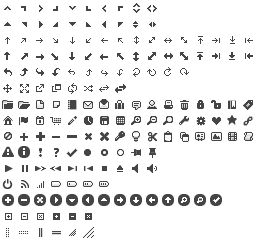
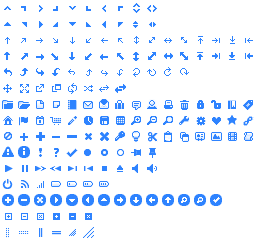
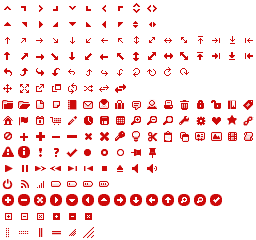
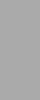
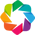
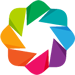
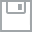
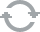
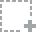
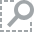
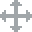
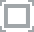
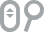

In [49]:
from bokeh.charts import TimeSeries, Bar, output_notebook, show
from bokeh.models import PrintfTickFormatter
output_notebook()

In [50]:
pd_by_dates = pd_by_dates.set_index("dt")
data = dict(count=pd_by_dates["cnt"], Date=pd_by_dates.index)

In [51]:
p = TimeSeries(data, index='Date', title="Searches per Day", 
               ylabel='Number of Searches', width=800, height=400)
p.background_fill = "#eaeef2"
show(p)

From the chart we can see that there are some clear patterns related to days of the week (especially in March). Also looks like something happened on the **17th of May** or (which is more likely) there is a case of missing data there.

In [52]:
from pandas import TimeGrouper

In [53]:
pd_71845_by_date = pd_71845.set_index("time")

In [54]:
pd_71845_by_date = pd_71845_by_date.groupby(TimeGrouper(freq='D')).count()

In [55]:
pd_71845_by_date.head()

id  query
time                    
2006-04-04    622    622
2006-04-05  44411  44411
2006-04-06  53846  53846
2006-04-07  52422  52422
2006-04-08  60224  60224

In [56]:
data = dict(count=pd_71845_by_date["id"], Date=pd_71845_by_date.index)

In [57]:
p = TimeSeries(data, index='Date', title="Searches per Day by 71845", 
               ylabel='Number of Searches', width=800, height=400)
p.background_fill = "#eaeef2"
show(p)

Looks like all searches done by 71845 occurred within 7 days which only confirms our first thought that it represents some anomaly.

There are almost endless ways we may want to slice-n-dice and analyse this dataset, but I guess, we've done enough to proof the concept so I will leave at this.

[Yuri Zhylyuk](http://yznotes.com) 2015